<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Présentation-du-projet" data-toc-modified-id="Présentation-du-projet-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Présentation du projet</a></span></li><li><span><a href="#Péparation-des-données" data-toc-modified-id="Péparation-des-données-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Péparation des données</a></span><ul class="toc-item"><li><span><a href="#Visualisation" data-toc-modified-id="Visualisation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Visualisation</a></span></li></ul></li><li><span><a href="#GAN" data-toc-modified-id="GAN-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>GAN</a></span><ul class="toc-item"><li><span><a href="#Generator" data-toc-modified-id="Generator-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Generator</a></span></li><li><span><a href="#Discriminateur" data-toc-modified-id="Discriminateur-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Discriminateur</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Résultats-par-GAN" data-toc-modified-id="Résultats-par-GAN-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Résultats par GAN</a></span></li></ul></li><li><span><a href="#AutoEncoder" data-toc-modified-id="AutoEncoder-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>AutoEncoder</a></span><ul class="toc-item"><li><span><a href="#Modification-du-dataset" data-toc-modified-id="Modification-du-dataset-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Modification du dataset</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Résultats-par-AE" data-toc-modified-id="Résultats-par-AE-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Résultats par AE</a></span></li></ul></li><li><span><a href="#TEST-ZONE" data-toc-modified-id="TEST-ZONE-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>TEST ZONE</a></span></li></ul></div>

# Présentation du projet


Dans ce projet, on va utiliser un GAN et un AE sur la base de données MNIST et les comparer.


# Péparation des données

In [2]:
# torch stuff
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F


# torchsummary and torchvision
from torchsummary import summary
import torchvision
from torchvision.utils import save_image
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.utils as vutils

# matplotlib stuff
import matplotlib.pyplot as plt
import matplotlib.image as img

# numpy and pandas
import numpy as np
import pandas as pd

# Common python packages
import datetime
import os
import sys
import time


CUDA = False and torch.cuda.is_available()
REAL_LABEL = 1
FAKE_LABEL = 0
seed = 1

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


dataset = datasets.MNIST(root='data', download=True,
                     transform=torchvision.transforms.Compose([
                     torchvision.transforms.Resize(64),
                     torchvision.transforms.ToTensor(),
                     torchvision.transforms.Normalize((0.5,), (0.5,))
                     ]))

# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128,
                                         shuffle=True, num_workers=2)


## Visualisation

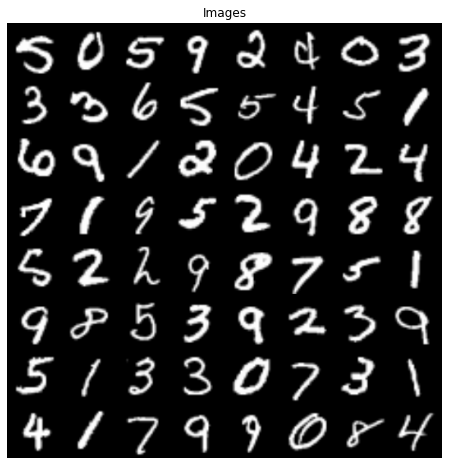

In [35]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


# GAN

## Generator


In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # 1st hidden layer
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # 2nd hidden layer
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # 3rd hidden layer
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # output layer
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

## Discriminateur

In [43]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 2nd layer
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 3rd layer
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 4th layer
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # output layer
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

## Training

In [8]:
EPOCH_NUM = 5
lr = 0.001

# Create the generator
generator = Generator().to(device)
#generator.apply(weights_init)
generator.load_state_dict(torch.load("MODEL/genarator"))
generator.eval()
print(generator)

# Create the discriminator
discriminator = Discriminator().to(device)
#discriminator.apply(weights_init)
generator.load_state_dict(torch.load("MODEL/genarator"))
generator.eval()
print(discriminator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [9]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(128, 100, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

> TRÈS LONG À COMPILER !!!

In [11]:

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(EPOCH_NUM):
    for i, data in enumerate(dataloader, 0):

        # (1) Update the discriminator with real data
        discriminator.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = discriminator(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # (2) Update the discriminator with fake data
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        # Generate fake image batch with G
        fake = generator(noise)
        label.fill_(FAKE_LABEL)
        # Classify all fake batch with discriminator
        output = discriminator(fake.detach()).view(-1)
        # Calculate discriminator loss on the all-fake batch
        errD_fake = criterion(output, label)
        errD_fake.backward()
        
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake

        optimizerD.step()

        # (3) Update the generator with fake data
        generator.zero_grad()
        label.fill_(REAL_LABEL) 
        # Since we just updated discrimator, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        
        # Calculate generator loss based on this output
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCH_NUM, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == EPOCH_NUM-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(viz_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/469]	Loss_D: 1.4672	Loss_G: 13.9034	D(x): 0.6042	D(G(z)): 0.6072 / 0.0000
[0/5][50/469]	Loss_D: 2.9033	Loss_G: 4.6404	D(x): 0.8985	D(G(z)): 0.9272 / 0.0134
[0/5][100/469]	Loss_D: 1.4901	Loss_G: 1.1150	D(x): 0.4198	D(G(z)): 0.4146 / 0.3548
[0/5][150/469]	Loss_D: 1.1049	Loss_G: 2.0837	D(x): 0.6400	D(G(z)): 0.4321 / 0.1648
[0/5][200/469]	Loss_D: 1.2541	Loss_G: 1.8006	D(x): 0.6622	D(G(z)): 0.5234 / 0.1894
[0/5][250/469]	Loss_D: 1.1215	Loss_G: 0.9949	D(x): 0.5459	D(G(z)): 0.3616 / 0.4044
[0/5][300/469]	Loss_D: 1.3025	Loss_G: 1.6203	D(x): 0.7353	D(G(z)): 0.5976 / 0.2220
[0/5][350/469]	Loss_D: 3.0447	Loss_G: 0.2571	D(x): 0.0615	D(G(z)): 0.0528 / 0.7868
[0/5][400/469]	Loss_D: 1.1749	Loss_G: 1.1600	D(x): 0.5833	D(G(z)): 0.4378 / 0.3278
[0/5][450/469]	Loss_D: 0.9939	Loss_G: 1.0191	D(x): 0.6135	D(G(z)): 0.3601 / 0.3811
[1/5][0/469]	Loss_D: 1.3518	Loss_G: 2.1257	D(x): 0.7836	D(G(z)): 0.6419 / 0.1362
[1/5][50/469]	Loss_D: 1.1644	Loss_G: 0.9672	D(x): 0.4761	D(G(z)):

In [12]:
torch.save(generator.state_dict(), "MODEL/genarator")
torch.save(discriminator.state_dict(), "MODEL/discriminator")

## Résultats par GAN

In [ ]:
# Si non run le training et recupérer l'ancien training
img_list = []
fake = generator(viz_noise).detach().cpu()
img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

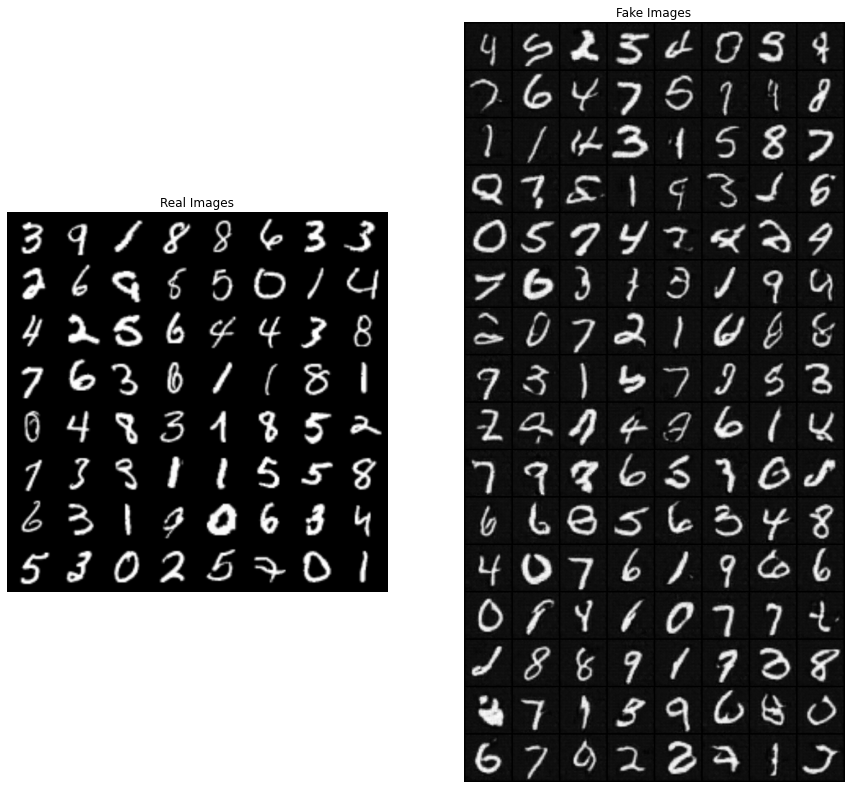

In [13]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# AutoEncoder
## Modification du dataset

In [90]:
import torchvision.transforms as transforms

# Define a new transform to convert PIL images to arrays
transform_to_array = transforms.Compose([transforms.ToTensor()])

# Load the MNIST dataset with the new transform
train_data = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=transform_to_array)
test_data = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=transform_to_array)

# Split the training data into training and validation sets
m = len(train_data)
train_data, val_data = torch.utils.data.random_split(train_data, [int(m - m * 0.2), int(m * 0.2)])

# Create data loaders with the new datasets
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)


In [91]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True))
        
        self.flatten = nn.Flatten(start_dim=1)

        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim))
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
    
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True))

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1))
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [92]:
criterion = torch.nn.MSELoss()
lr= 0.001

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

encoder.load_state_dict(torch.load("MODEL/encoder"))
encoder.eval()
print(encoder)

decoder.load_state_dict(torch.load("MODEL/decoder"))
decoder.eval()
print(decoder)


Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)
Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kern

## Training

In [96]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for i, (image_batch, _) in enumerate(dataloader):
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        if i % 100 == 0:
            print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [97]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): 
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

> LONG À COMPILER !!!

In [98]:
num_epochs = 30
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss =train_epoch(encoder,decoder,device, train_loader,criterion,optim)
    val_loss = test_epoch(encoder,decoder,device,test_loader,criterion)
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)

	 partial train loss (single batch): 0.038010
	 partial train loss (single batch): 0.037363

 EPOCH 1/30 	 train loss 0.036911722272634506 	 val loss 0.036563459783792496
	 partial train loss (single batch): 0.035256
	 partial train loss (single batch): 0.036105

 EPOCH 2/30 	 train loss 0.03564641252160072 	 val loss 0.035543374717235565
	 partial train loss (single batch): 0.035950
	 partial train loss (single batch): 0.034641

 EPOCH 3/30 	 train loss 0.03457038104534149 	 val loss 0.03476472944021225
	 partial train loss (single batch): 0.034122
	 partial train loss (single batch): 0.032346

 EPOCH 4/30 	 train loss 0.03359118103981018 	 val loss 0.03350401669740677
	 partial train loss (single batch): 0.033095
	 partial train loss (single batch): 0.033855

 EPOCH 5/30 	 train loss 0.03272639587521553 	 val loss 0.03261744603514671
	 partial train loss (single batch): 0.032559
	 partial train loss (single batch): 0.031726

 EPOCH 6/30 	 train loss 0.03191965073347092 	 val loss 0.0

In [99]:
# saving our training
torch.save(encoder.state_dict(), "MODEL/encoder")
torch.save(decoder.state_dict(), "MODEL/decoder")

## Résultats par AE

tensor([ 0.2439, -0.1179,  0.1109,  0.2075])
tensor([0.5713, 0.6923, 0.7032, 0.4923])


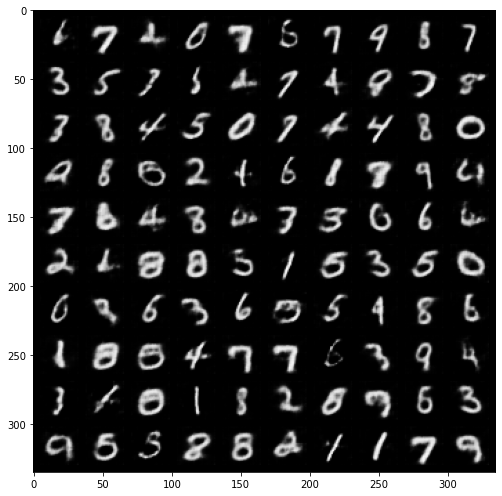

tensor([ 0.2407, -0.0885,  0.1571,  0.1913])
tensor([0.6354, 0.7386, 0.7226, 0.4926])


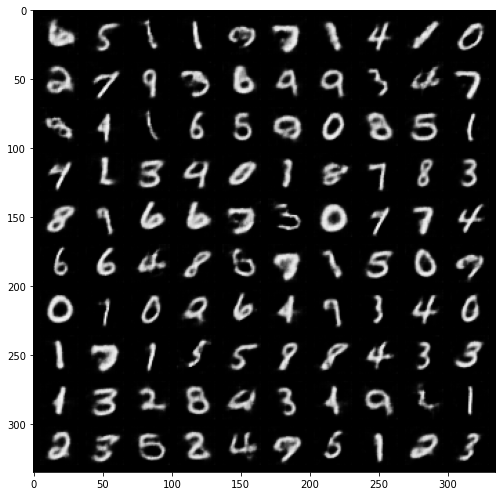

tensor([ 0.1882, -0.0710,  0.0922,  0.2353])
tensor([0.6279, 0.7629, 0.6709, 0.5282])


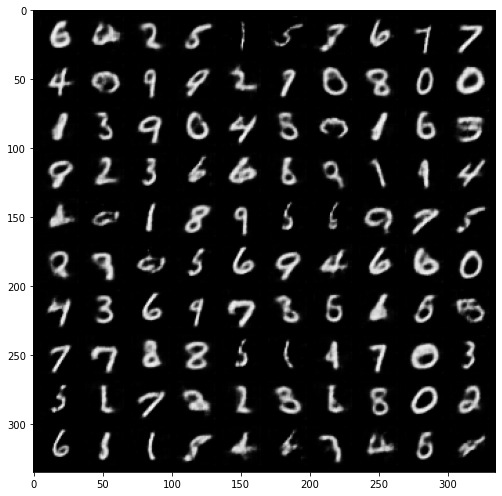

tensor([ 0.2459, -0.0795,  0.1309,  0.2469])
tensor([0.6204, 0.7971, 0.7048, 0.5276])


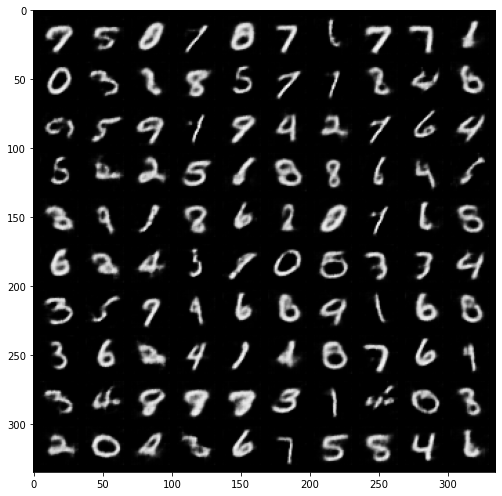

tensor([ 0.2544, -0.1241,  0.1197,  0.2985])
tensor([0.6331, 0.7580, 0.7178, 0.4728])


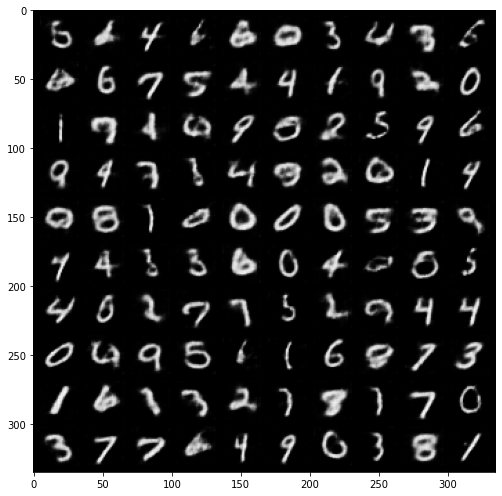

tensor([ 0.2004, -0.1720,  0.0429,  0.2269])
tensor([0.6261, 0.7526, 0.7180, 0.5630])


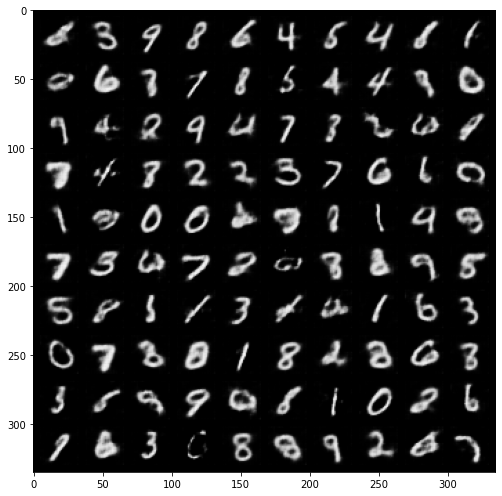

tensor([ 0.2219, -0.0460,  0.0871,  0.2393])
tensor([0.6642, 0.7138, 0.7568, 0.4947])


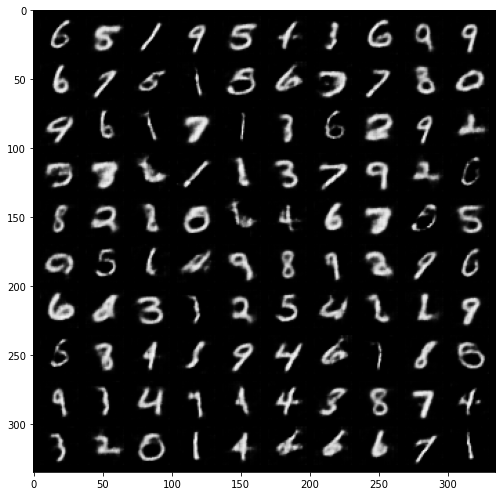

tensor([ 0.3284, -0.1799,  0.1699,  0.2430])
tensor([0.6540, 0.7729, 0.6976, 0.4715])


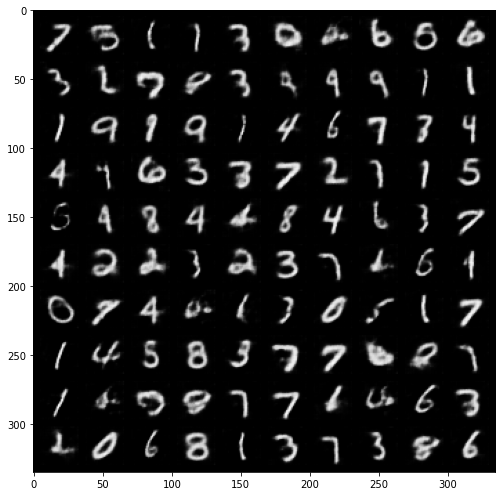

tensor([ 0.2959, -0.1356,  0.1207,  0.2459])
tensor([0.6827, 0.8064, 0.7570, 0.5162])


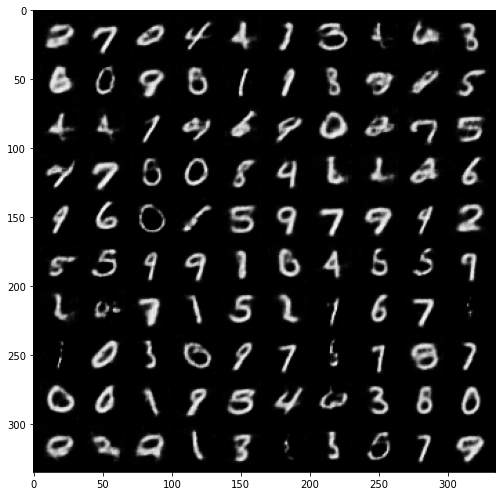

tensor([ 0.2710, -0.0819,  0.0927,  0.2618])
tensor([0.6246, 0.7974, 0.6909, 0.4658])


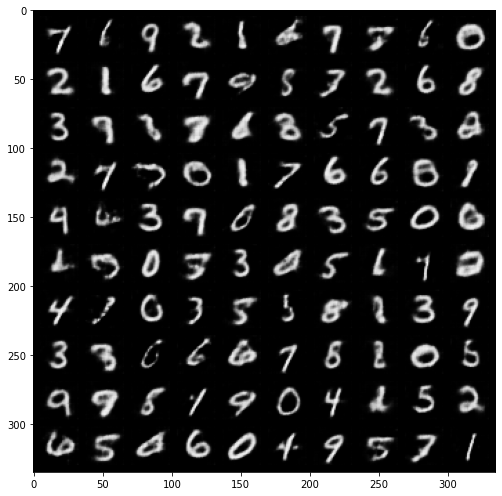

tensor([ 0.3164, -0.1993,  0.0868,  0.2583])
tensor([0.6238, 0.8537, 0.7028, 0.5043])


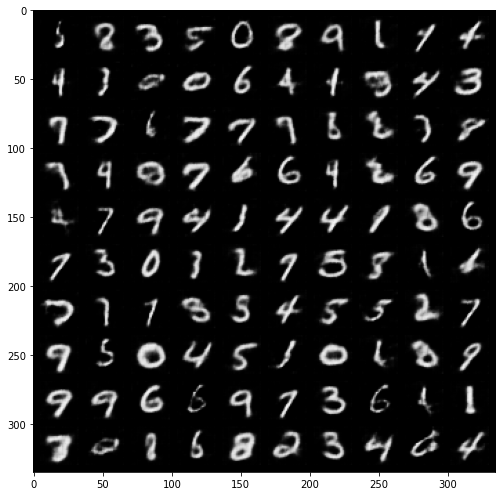

tensor([ 0.2639, -0.1533,  0.0962,  0.2311])
tensor([0.6498, 0.7970, 0.7264, 0.5162])


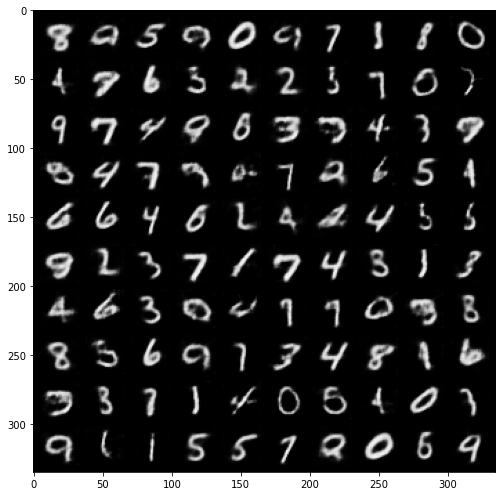

tensor([ 0.2346, -0.0932,  0.0886,  0.2064])
tensor([0.6146, 0.7347, 0.6888, 0.4809])


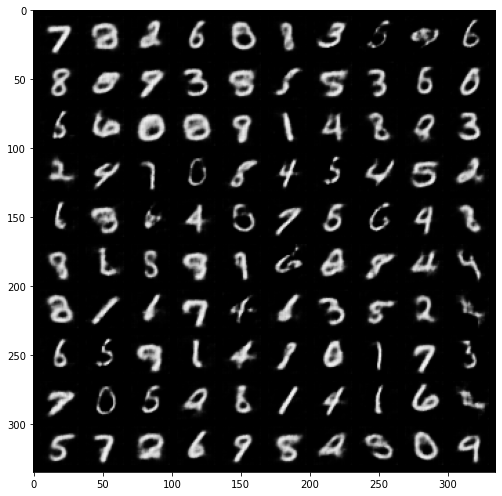

tensor([ 0.2524, -0.0919,  0.1229,  0.2699])
tensor([0.6173, 0.7990, 0.7096, 0.5518])


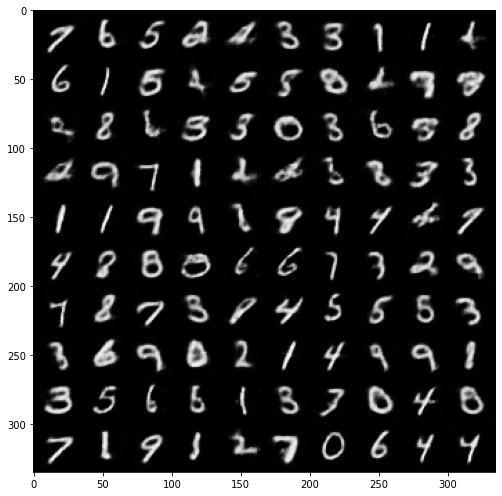

tensor([ 0.3328, -0.0769,  0.1057,  0.1429])
tensor([0.6775, 0.6947, 0.7433, 0.5057])


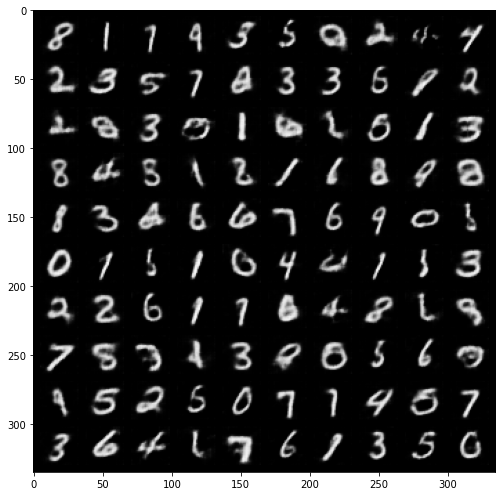

tensor([ 0.2410, -0.1449,  0.1489,  0.2403])
tensor([0.6829, 0.7805, 0.7303, 0.5085])


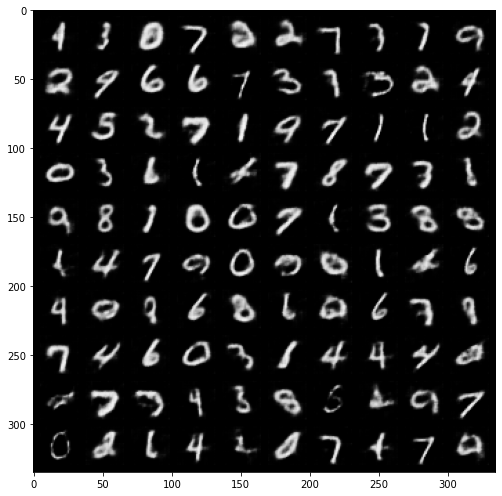

tensor([ 0.2818, -0.0978,  0.1442,  0.1914])
tensor([0.6633, 0.7173, 0.6904, 0.5182])


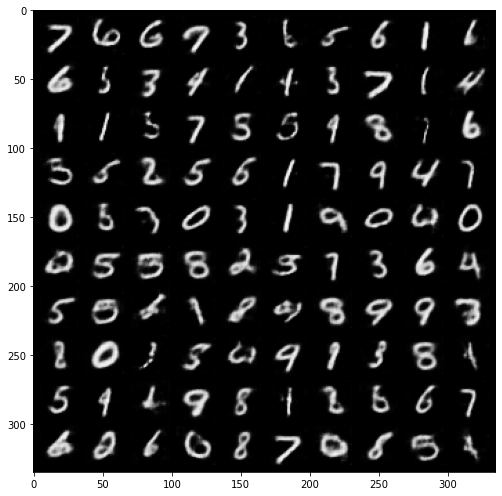

tensor([ 0.2537, -0.0613,  0.1865,  0.2357])
tensor([0.6361, 0.7817, 0.7144, 0.4728])


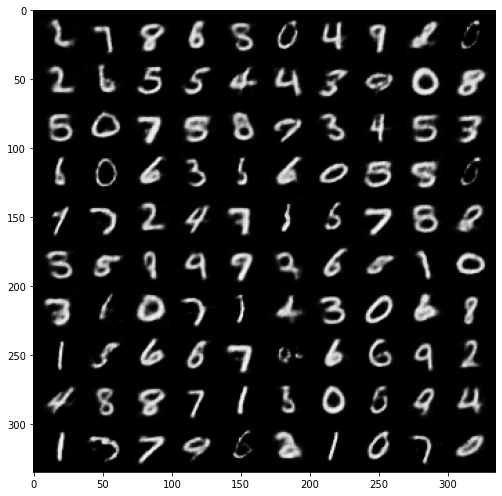

In [ ]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        latent = encoder(images)
        latent = latent.cpu()

        mean = latent.mean(dim=0)
        print(mean)
        std = (latent - mean).pow(2).mean(dim=0).sqrt()
        print(std)

        # sample latent vectors from the normal distribution
        latent = torch.randn(128, d)*std + mean

        # reconstruct images from the random latent vectors
        latent = latent.to(device)
        img_recon = decoder(latent)
        img_recon = img_recon.cpu()

        fig, ax = plt.subplots(figsize=(20, 8.5))
        show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
        plt.show()

# TEST ZONE